# importing libraries to use

In [ ]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [ ]:
# importing(loading) dataset 
data=pd.read_csv("customer_segmentation.csv")

In [ ]:
data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'payment_installments', 'payment_value',
       'customer_unique_id', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'seller_city', 'seller_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_category_name_english'],
      dtype='object')

# descriptive analysis


In [ ]:
data.describe()

payment_installments  payment_value  order_item_id         price  \
count          13801.000000   13801.000000   13801.000000  13801.000000   
mean               3.014637     194.349691       1.230491    130.947103   
std                2.801721     294.854258       0.737495    210.712421   
min                1.000000       0.050000       1.000000      0.850000   
25%                1.000000      66.750000       1.000000     40.000000   
50%                2.000000     120.290000       1.000000     79.000000   
75%                4.000000     206.780000       1.000000    139.000000   
max               20.000000    7274.880000      13.000000   4590.000000   

       freight_value  product_name_lenght  product_description_lenght  
count   13801.000000         13801.000000                13801.000000  
mean       21.938168            49.300703                  814.330411  
std        18.567013             9.759529                  648.790194  
min         0.000000             8.000000                    4.000000  
25%        12.870000            43.000000                  366.000000  
50%        18.230000            52.000000                  631.000000  
75%        23.310000            57.000000                 1030.000000  
max       375.280000            69.000000                 3985.000000

# checking if dataset is balanced
To determine if the dataset is balanced in terms of price and customer_city distribution

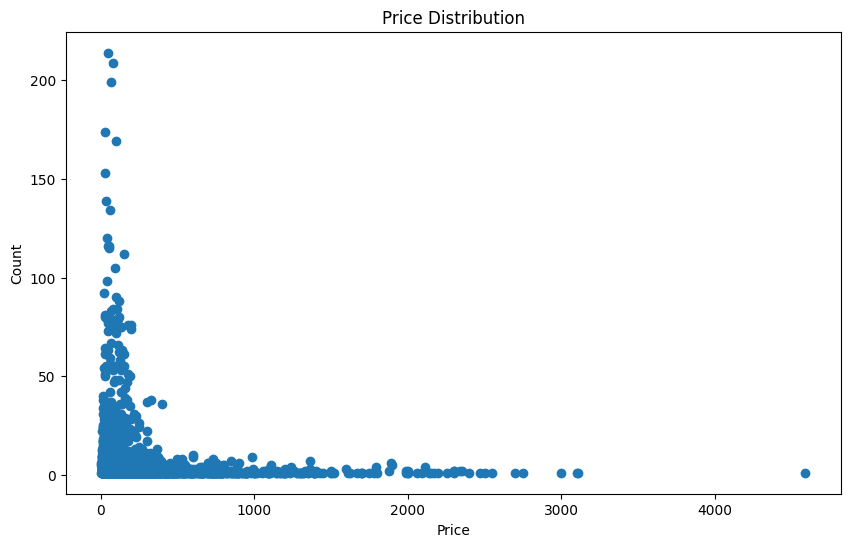

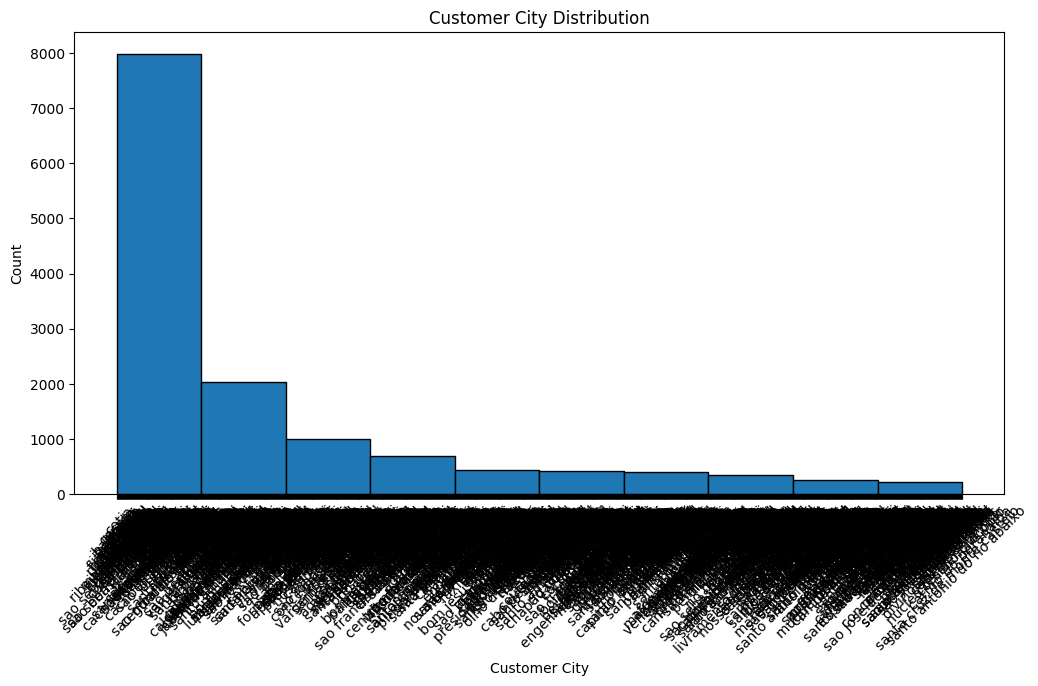

Price Balance: False
Customer City Balance: False


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'data' containing the relevant variables

# Check the balance of the dataset based on price
price_counts = data['price'].value_counts()
num_unique_prices = len(price_counts)

# Plot the distribution of prices using scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(price_counts.index, price_counts.values)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

# Check the balance of the dataset based on customer_city
city_counts = data['customer_city'].value_counts()
num_unique_cities = len(city_counts)

# Check the balance of the dataset based on customer_city
plt.figure(figsize=(12, 6))
plt.hist(data['customer_city'], bins=10, edgecolor='black')
plt.title('Customer City Distribution')
plt.xlabel('Customer City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Determine if the dataset is balanced based on price
is_price_balanced = num_unique_prices <= 0.1  # If the number of unique values is greater or equal to 20% of the total dataset size (approximately 2,600 unique values), you can consider it moderately balanced.

# Determine if the dataset is balanced based on customer_city
is_city_balanced = num_unique_cities <= 0.1  # If the number of unique values is greater  or equal to 20% of the total dataset size (approximately 2,600 unique values), you can consider it moderately balanced.

# Print the results
print("Price Balance:", is_price_balanced)
print("Customer City Balance:", is_city_balanced)


# interpretation:
the data is not balanced according to price and customer city

# data cleaning 
Preprocess the dataset (check duplicates, remove duplicates,checking for outliers, check missing values and  impute NaNs,).

In [ ]:
# check for duplicates
def has_duplicates(data):
    frequency = {}
    
    for item in data:
        if item in frequency:
            return True
        else:
            frequency[item] = 1
    
    return False
result = has_duplicates(data)
print(result)

False


# INTERPRETATION:
there is no duplicates in our dataset, no need to drop them

In [ ]:


# Check for anomalies(outliers)
# Example: Visualize a numerical feature 'price' using a box plot
data['price'].plot(kind='box')


<Axes: >

# interpretation: 
according to price there is outliers based on box plot

# checking for missing values

In [ ]:
data.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_type                     0
payment_installments             0
payment_value                    0
customer_unique_id               0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
seller_city                      0
seller_state                     0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_category_name_english    0
dtype: int64

# interpretation:
there is no missing values in the dataset

In [ ]:
print(data['order_purchase_timestamp'])

0        2018-07-24 20:41:37
1        2018-08-09 11:37:35
2        2018-07-09 18:46:28
3        2018-08-21 10:00:25
4        2018-08-21 10:00:25
                ...         
13796    2018-07-15 09:56:32
13797    2018-05-07 20:36:47
13798    2018-04-28 14:32:54
13799    2018-07-11 22:27:32
13800    2018-08-07 10:52:58
Name: order_purchase_timestamp, Length: 13801, dtype: object


# calculate the RFM values for each customer

In [ ]:
# Convert 'order_purchase_timestamp' to datetime
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

# Calculate recency by subtracting the latest date from 'order_purchase_timestamp'
latest_date = data['order_purchase_timestamp'].max()
data['recency'] = (latest_date - data['order_purchase_timestamp']).dt.days

# Sort the data by customer ID and order purchase timestamp
data.sort_values(['customer_id', 'order_purchase_timestamp'], inplace=True)

# Calculate the cumulative sum of orders per customer
data['frequency'] = data.groupby('customer_id').cumcount() + 1


# Calculate monetary value by summing 'payment_value' for each customer
data['monetary'] = data.groupby('customer_id')['payment_value'].transform('sum')

# Select relevant columns for RFM analysis
rfm_data = data[['customer_id', 'recency', 'frequency', 'monetary']]


In [ ]:
rfm_data

customer_id  recency  frequency  monetary
11236  001051abfcfdbed9f87b4266213a5df1       91          1     65.20
11237  001051abfcfdbed9f87b4266213a5df1       91          2     65.20
11238  001051abfcfdbed9f87b4266213a5df1       91          3     65.20
7660   0013cd8e350a7cc76873441e431dd5ee      113          1     92.60
11727  0015bc9fd2d5395446143e8b215d7c75       78          1    132.19
...                                 ...      ...        ...       ...
115    fff5169e583fd07fac9fec88962f189d      109          1    152.77
13248  fff93c1da78dafaaa304ff032abc6205       77          1    727.44
13249  fff93c1da78dafaaa304ff032abc6205       77          2    727.44
13253  fff93c1da78dafaaa304ff032abc6205       77          3    727.44
8470   ffff42319e9b2d713724ae527742af25       76          1    214.13

[13801 rows x 4 columns]

In [ ]:
print(rfm_data['frequency'])

11236    1
11237    2
11238    3
7660     1
11727    1
        ..
115      1
13248    1
13249    2
13253    3
8470     1
Name: frequency, Length: 13801, dtype: int64


# analysis of our new features created

In [ ]:
# Print the number of customers for each frequency
frequency_counts = data['frequency'].value_counts().sort_index()
print(frequency_counts)

1     11394
2      1636
3       388
4       180
5        95
6        63
7        16
8         7
9         6
10        6
11        5
12        4
13        1
Name: frequency, dtype: int64


# Standardize the RFM variables

In [ ]:
# Standardize the RFM variables using StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['recency', 'frequency', 'monetary']])
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['recency', 'frequency', 'monetary'])


# Apply K-means clustering

In [ ]:
# Determine the optimal number of clusters using the elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
import matplotlib.pyplot as plt
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

# INTERPRETATION:

the number accurate of segments are 4

#  Assign cluster labels to customers

In [ ]:
# Choose the optimal number of clusters based on the elbow curve analysis
n_clusters = 4

# Apply K-means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(rfm_scaled)
rfm_data['cluster'] = kmeans.labels_ + 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-15-c8e82db05ff0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_data['cluster'] = kmeans.labels_ + 1


In [ ]:
rfm_data.describe()

recency     frequency      monetary       cluster
count  13801.000000  13801.000000  13801.000000  13801.000000
mean      73.765089      1.289834    395.473717      2.009782
std       42.504924      0.836689   1186.680000      0.980523
min        0.000000      1.000000     13.890000      1.000000
25%       35.000000      1.000000     73.270000      1.000000
50%       75.000000      1.000000    139.970000      2.000000
75%      111.000000      1.000000    298.480000      3.000000
max      481.000000     13.000000  29099.520000      4.000000

# assign segment labels to our customer
these segment are based on recency,frequency and monetary value. where at-risk customer: customer purchased more than 100 days ago, once and with few money. potential loyalist customers: averaged of 82 days purchased more than twice and with huge amount of money more than 1000. new customers are recent customer came once but huge amount. loyal customer came for average more than 4 times and huge amount too.

In [ ]:
# Calculate segment-wise statistics
segment_stats = rfm_data.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'customer_id': 'count'
})
segment_stats.columns = ['avg_recency', 'avg_frequency', 'avg_monetary', 'customer_count']

# Print segment statistics
print(segment_stats)

# Analyze each segment and develop strategies
for cluster_num, segment_data in rfm_data.groupby('cluster'):
    print('Segment:', cluster_num)
    print('Number of Customers:', len(segment_data))
    
    if cluster_num == 1:
        # At-Risk customers
        print('Segment Description: At-Risk Customers')

    elif cluster_num == 2:
        # Potential loyalists customers
        print('Segment Description: Potential Loyalists Customers')

    elif cluster_num == 3:
        # New Customers
        print('Segment Description: New Customers')

    elif cluster_num == 4:
        # Loyal Customers
        print('Segment Description: Loyal Customers')


    print('---')


         avg_recency  avg_frequency  avg_monetary  customer_count
cluster                                                          
1         109.915935       1.131640    276.194722            6495
2          81.236631       3.899733   1621.364519             748
3          36.602374       1.115171    232.873185            6486
4          82.777778       4.180556  13067.387639              72
Segment: 1
Number of Customers: 6495
Segment Description: At-Risk Customers
---
Segment: 2
Number of Customers: 748
Segment Description: Potential Loyalists Customers
---
Segment: 3
Number of Customers: 6486
Segment Description: New Customers
---
Segment: 4
Number of Customers: 72
Segment Description: Loyal Customers
---


# describing the segment created

In [ ]:
segment_stats.describe()

avg_recency  avg_frequency  avg_monetary  customer_count
count     4.000000       4.000000      4.000000        4.000000
mean     77.633180       2.581775   3799.455016     3450.250000
std      30.359815       1.687891   6212.152670     3521.411116
min      36.602374       1.115171    232.873185       72.000000
25%      70.078067       1.127523    265.364338      579.000000
50%      82.007204       2.515686    948.779620     3617.000000
75%      89.562317       3.969938   4482.870299     6488.250000
max     109.915935       4.180556  13067.387639     6495.000000

# analysing segment

# checking the segment revenue
checking the segments wwhich bring the highest revenue to us.

cluster
1    1793884.72
2    1212780.66
3    1510415.48
4     940851.91
Name: monetary, dtype: float64


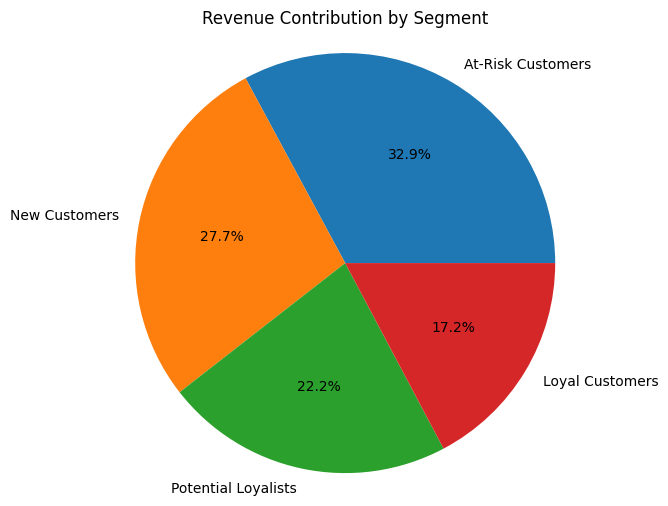

In [ ]:
import matplotlib.pyplot as plt

# Sort the segment revenues in descending order
segment_revenue = rfm_data.groupby('cluster')['monetary'].sum()
print(segment_revenue)
highest_revenue_segments = segment_revenue.sort_values(ascending=False)

# Define the segment names
segment_names = {
    1: "At-Risk Customers",
    2: "Potential Loyalists",
    3: "New Customers",
    4: "Loyal Customers"
}

# Replace the labels with segment names
segment_labels = highest_revenue_segments.index.map(segment_names)

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(highest_revenue_segments, labels=segment_labels, autopct='%1.1f%%')
plt.title('Revenue Contribution by Segment')

plt.axis('equal')
plt.show()
